# Analysis of MTA Data for Metis Benson Project

In [1]:
'''
Read in MTA data and do some checks and cleanup.

Each row in an MTA data file contains the following items:
C/A      = Control Area (a block of turnstiles);
UNIT     = Remote Unit, unique ID for a subway station;
SCP      = Number designating a single turnstile;
STATION  = Station name;
LINENAME = Concatenation of names of lines going through station (e.g. NQR456, BD,...);
DIVISION = A throwback to the time when there were three separate subway systems:
              IRT = Interborough Rapid Transit;
              BMT = Brooklyn-Manhattan Transit;
              IND = Independent Subway;
           In addition, there are also the following divisions:
              PTH = Port Authority Trans-Hudson (PATH);
              RIT = Roosevelt Island Tram;
              SRT = Staten Island Rapid Transit;
DATE     = Date on which data were collected;
TIME     = Time of collection (every four hours);
DESC     = This is either "REGULAR" or "RECOVR AUD"
ENTRIES  = State of entries counter at turnstile at given date and time;
EXITS    = State of exits counter at turnstile at given date and time.
Note: Entries and exits counters get reset regularly, but not quite predictably.
'''
from __future__ import division
import csv
from datetime import datetime
from collections import Counter
from collections import defaultdict
from pprint import pprint

# Command line command to fetch the data:
# !curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150404.txt

# Read in the data.
mta_file = 'turnstile_150404_original.txt'
with open(mta_file) as f:
    reader = csv.reader(f)
    rows = [[cell.strip() for cell in row] for row in reader]
print('Number of records read in: %i' % len(rows))

# Make sure header row of data file is what we expect it to be.
assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 
                       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'], \
       'Unexpected header row in file "%s"' % mta_file

# Create dictionary with turnstile IDs as keys and the remaining information as values.
raw_readings = {}
for row in rows:
    raw_readings.setdefault(tuple(row[:4]), []).append(tuple(row[4:]))

# Create dictionary with turnstile IDs as keys and (date-time, cumulative entrances) as values.
datetime_cumulative = {turnstile: [(datetime.strptime(date + time,'%m/%d/%Y%X'),int(in_cumulative))
                                   for _, _, date, time, _, in_cumulative, _ in rows]
                       for turnstile, rows in raw_readings.items()}

# Check that each row in datetime_cumulative is sorted by increasing date/time.
for row in datetime_cumulative.values():
    assert row == sorted(row,key=lambda x: x[0]), 'Row with unsorted times: "%s"' % row

# Create dictionary with turnstile IDs as keys and 
# [[start time, number of entrances in delta time, delta time],...] as values.
datetime_count_times = {turnstile: [[rows[i][0], rows[i+1][1] - rows[i][1], rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative.items()}

# Create dictionary with turnstile IDs as keys and [(start time, number of entrances in delta time),...]
# as values.  Remove entries which have a count below 0 or above 5000.
datetime_counts = {turnstile: [(time, count) for (time, count, _) in rows if 0 <= count <= 5000]
                   for turnstile, rows in datetime_count_times.items()}

# Check how the size of the dataset changed after filtering out bad counts.
ndata1 = sum(len(rows) for rows in datetime_count_times.values())
ndata2 = sum(len(rows) for rows in datetime_counts.values())
print('Initial data set size: %i, after counts filter: %i (rejections: %i)' %(ndata1,ndata2,ndata1-ndata2))

# Create a dictionary with turnstile IDs as keys and [(day, number of entrances),...] as values.
day_counts = {}
for turnstile, rows in datetime_counts.items():
    by_day = {}
    for time, count in rows:
        day = time.date()
        by_day[day] = by_day.get(day, 0) + count
    day_counts[turnstile] = sorted(by_day.items())

print('Number of turnstiles = %i' %len(day_counts))

# List the station IDs that share a name.
stations_byname = {}
for turnstile in datetime_counts.keys():
    stid   = turnstile[1]
    stname = turnstile[3]
    stations_byname.setdefault(stname,set()).add(stid)
print('\nStations with more than 4 IDs:')
for stname,stid in stations_byname.items():
    if len(stid) >= 4:
        print('  Station "%s" has IDs %s' %(stname,sorted(list(stid))))
print

# Now that we have clean data by turnstile, we can group by station.
station_day_counts = {}
for turnstile,rows in day_counts.items():
    station = turnstile[3]
    station_day_counts.setdefault(station,{})
    for day,count in rows:
        station_day_counts[station][day] = station_day_counts[station].get(day,0) + count
for station,rows in station_day_counts.items():
    station_day_counts[station] = sorted(rows.items())
print('Number of stations (by name) = %i' %len(station_day_counts))

# Finally, sum over days.
station_counts = {station: sum(x[1] for x in rows) for station,rows in station_day_counts.items()}
print('\nList of ten most crowded stations:')
print sorted(station_counts.items(),key=lambda x: x[1],reverse=True)[:10]

Number of records read in: 191386
Initial data set size: 186827, after counts filter: 185731 (rejections: 1096)
Number of turnstiles = 4558

Stations with more than 4 IDs:
  Station "42 ST-GRD CNTRL" has IDs ['R045', 'R046', 'R047', 'R048']
  Station "34 ST-PENN STA" has IDs ['R012', 'R013', 'R031', 'R293']
  Station "125 ST" has IDs ['R034', 'R102', 'R132', 'R206']
  Station "CANAL ST" has IDs ['R118', 'R139', 'R320', 'R462', 'R463']
  Station "86 ST" has IDs ['R167', 'R179', 'R186', 'R215', 'R397']

Number of stations (by name) = 381

List of ten most crowded stations:
[('34 ST-PENN STA', 1057842), ('42 ST-GRD CNTRL', 882054), ('34 ST-HERALD SQ', 737871), ('86 ST', 697851), ('14 ST-UNION SQ', 678753), ('42 ST-TIMES SQ', 606133), ('42 ST-PA BUS TE', 576786), ('96 ST', 485493), ('125 ST', 484752), ('59 ST-COLUMBUS', 454134)]


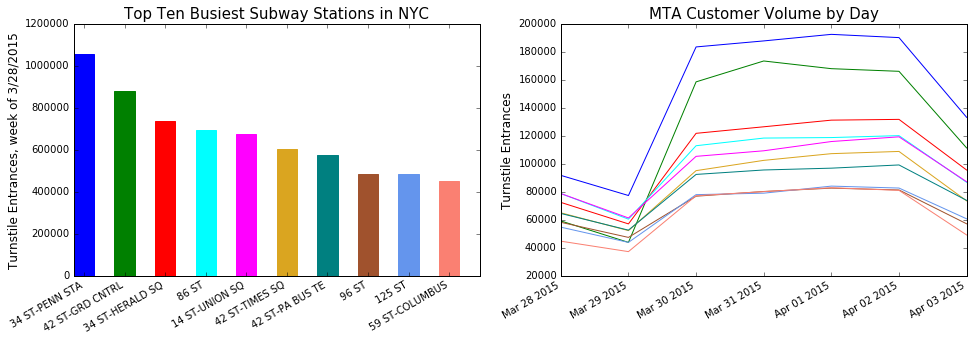

In [2]:
'''
Make a couple of plots:
1. a bar chart showing the number of entrances in the week of 3/28/2015 for the ten busiest subway stations;
2. a line plot showing the number of entrances per day for the week of 3/28/2015, for the ten busiest stations.
'''
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Ndata  = 10
colors = ['blue','green','red','cyan','magenta','goldenrod','teal','sienna','cornflowerblue','salmon']
busiest_stations = sorted(station_counts.items(),key=lambda x: x[1],reverse=True)[:Ndata]
entrances        = [busiest_stations[i][1] for i in range(Ndata)]
top_stations     = [busiest_stations[i][0] for i in range(Ndata)]

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(16,5) )
Xlocs     = np.arange(Ndata)
width     = 0.50
barlist   = axes[0].bar( Xlocs, entrances, width )
axes[0].set_ylabel('Turnstile Entrances, week of 3/28/2015',fontsize=12)
axes[0].set_title('Top Ten Busiest Subway Stations in NYC',fontsize=15)
axes[0].set_xticks(Xlocs+0.5*width)
axes[0].set_xticklabels(top_stations)
for bar in range(Ndata):
    barlist[bar].set_color(colors[bar])

for ind,station in enumerate(top_stations):
    days   = [date for (date,_) in station_day_counts[station]]
    counts = [count for (_,count) in station_day_counts[station]]
    axes[1].plot(days,counts,color=colors[ind])
    axes[1].set_ylabel('Turnstile Entrances',fontsize=12)
    axes[1].set_title('MTA Customer Volume by Day',fontsize=15)
    
fig.autofmt_xdate() # Rotate x-axis tick labels    
plt.show()
fig.savefig('MTA_volume.png')